In [1]:
import PIL
from PIL import Image, ImageDraw, ImageFilter, ImageFont
 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import signal
from scipy import misc
from scipy import ndimage
from scipy.stats import multivariate_normal
from numpy.linalg import norm
import numpy.linalg
from skimage.feature import hog
from skimage import data, exposure
import numpy as np
import scipy.stats as st
import heapq
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
from tempfile import TemporaryFile

In [2]:
#input 
    ##imageName: original image (.jpg, .bmp, .gif)
    
#output
    ##doubled_img:is the original image upsampled to double size
    ##normal_img: is the origianl image
    ##halved_img: is the original image subsampled to a half size
    ##quartered_img: is the original image subsampled to a quarter size
    ## in the following a Gaussian blurred image is composed by convolving the image with a Gaussian function 
    ## with a known sigma
    ##pyrlvl1: data structure contains 6 Gaussian blurred versions of doubled_img
    ##pyrlvl2: data structure contains 6 Gaussian blurred versions of normal_img
    ##pyrlvl3: data structure contains 6 Gaussian blurred versions of halved_img
    ##pyrlvl4: data structure contains 6 Gaussian blurred versions of quartered_img
    ##diffpyrlvl1: data structure contains 5 DoG images of doubled_img
    ##diffpyrlvl2: data structure contains 5 DoG images of normal_img
    ##diffpyrlvl3: data structure contains 5 DoG images of halved_img
    ##diffpyrlvl4: data structure contains 5 DoG images of quartered_img

#description
    ##this methos builds the Pyramid Tiles of the original image
    
def buildImageTiles(imageName):
    #original = ndimage.imread(imagename, flatten=True)
    #original = plt.imread(imagename)
    
    original = Image.open(imageName)

    # SIFT Parameters
    s = 3
    k = 2 ** (1.0 / s)
    # threshold variable is the contrast threshold. Set to at least 1

    # Standard deviations for Gaussian smoothing
    kvec1 = np.array([1.3, 1.6, 1.6 * k, 1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4)])
    kvec2 = np.array([1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4), 1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7)])
    kvec3 = np.array([1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7), 1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10)])
    kvec4 = np.array([1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10), 1.6 * (k ** 11), 1.6 * (k ** 12), 1.6 * (k ** 13)])
    kvectotal = np.array([1.6, 1.6 * k, 1.6 * (k ** 2), 1.6 * (k ** 3), 1.6 * (k ** 4), 1.6 * (k ** 5), 1.6 * (k ** 6), 1.6 * (k ** 7), 1.6 * (k ** 8), 1.6 * (k ** 9), 1.6 * (k ** 10), 1.6 * (k ** 11)])

    # Resampling - up/downsampling images
    doubled_img = original.resize((2*original.size[0], 2*original.size[1]), PIL.Image.BILINEAR)
    normal_img = doubled_img.resize((int(float(doubled_img.size[0]/2)), int(float(doubled_img.size[1]/2))), PIL.Image.BILINEAR)
    halved_img = normal_img.resize((int(float(normal_img.size[0]/2)), int(float(normal_img.size[1]/2))), PIL.Image.BILINEAR)
    quartered_img = halved_img.resize((int(float(halved_img.size[0]/2)), int(float(halved_img.size[1]/2))), PIL.Image.BILINEAR)
    
    #convert image to grey levels then to arrays
    doubled = np.asarray(doubled_img.convert('L'))
    normal = np.asarray(normal_img.convert('L'))
    halved = np.asarray(halved_img.convert('L'))
    quartered = np.asarray(quartered_img.convert('L'))

    # Initialize Gaussian pyramids
    pyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 6))
    pyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 6))
    pyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 6))
    pyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 6))

    print("Constructing pyramids...")

    # Construct Gaussian pyramids
    for i in range(0, 6):
        pyrlvl1[:,:,i] = ndimage.filters.gaussian_filter(doubled, kvec1[i])
        
        temp = ndimage.filters.gaussian_filter(doubled, kvec2[i])
        pyrlvl2[:,:,i] = Image.fromarray(temp).resize((int(float(doubled.shape[1]/2)), int(float(doubled.shape[0]/2))), PIL.Image.BILINEAR)
        
        temp = ndimage.filters.gaussian_filter(doubled, kvec3[i])
        pyrlvl3[:,:,i] = Image.fromarray(temp).resize((int(float(doubled.shape[1]/4)), int(float(doubled.shape[0]/4))), PIL.Image.BILINEAR)
        
        temp = ndimage.filters.gaussian_filter(doubled, kvec4[i])
        pyrlvl4[:,:,i] = Image.fromarray(temp).resize((int(float(doubled.shape[1]/8)), int(float(doubled.shape[0]/8))), PIL.Image.BILINEAR)
     
    # Initialize Difference-of-Gaussians (DoG) pyramids
    diffpyrlvl1 = np.zeros((doubled.shape[0], doubled.shape[1], 5))
    diffpyrlvl2 = np.zeros((normal.shape[0], normal.shape[1], 5))
    diffpyrlvl3 = np.zeros((halved.shape[0], halved.shape[1], 5))
    diffpyrlvl4 = np.zeros((quartered.shape[0], quartered.shape[1], 5))

    # Construct DoG pyramids
    for i in range(0, 5):
        diffpyrlvl1[:,:,i] = pyrlvl1[:,:,i+1] - pyrlvl1[:,:,i]
        diffpyrlvl2[:,:,i] = pyrlvl2[:,:,i+1] - pyrlvl2[:,:,i]
        diffpyrlvl3[:,:,i] = pyrlvl3[:,:,i+1] - pyrlvl3[:,:,i]
        diffpyrlvl4[:,:,i] = pyrlvl4[:,:,i+1] - pyrlvl4[:,:,i]
    
    return (doubled_img, normal_img, halved_img, quartered_img, pyrlvl1, pyrlvl2, pyrlvl3, pyrlvl4, diffpyrlvl1, diffpyrlvl2, diffpyrlvl3, diffpyrlvl4)

In [3]:
#input
    ##doubled_img:is the original image upsampled to double size
    ##normal_img: is the origianl image
    ##halved_img: is the original image subsampled to a half size
    ##quartered_img: is the original image subsampled to a quarter size
    
    ##pyrlvl1: data structure contains 6 Gaussian blurred versions of doubled_img
    ##pyrlvl2: data structure contains 6 Gaussian blurred versions of normal_img
    ##pyrlvl3: data structure contains 6 Gaussian blurred versions of halved_img
    ##pyrlvl4: data structure contains 6 Gaussian blurred versions of quartered_img
    
    ##diffpyrlvl1: data structure contains 5 DoG images of doubled_img
    ##diffpyrlvl2: data structure contains 5 DoG images of normal_img
    ##diffpyrlvl3: data structure contains 5 DoG images of halved_img
    ##diffpyrlvl4: data structure contains 5 DoG images of quartered_img
    
#output
    ##a display of all images in the pyramid tile
    
#description
    ##this method is purely a displaying method
    
def showPyramidTiles(doubled_img, normal_img, halved_img, quartered_img, pyrlvl1, pyrlvl2, pyrlvl3, pyrlvl4, diffpyrlvl1, diffpyrlvl2, diffpyrlvl3, diffpyrlvl4):
    #setting all images in the pyramid for diplaying:
    %matplotlib inline  
    fig = plt.figure()
    fig.add_subplot(1,7,1)
    imgplot = plt.imshow(doubled_img)
    #showing level 1 Gaussian_blurred images:
    #image 0:
    ##img = Image.fromarray(np.uint8(pyrlvl1[:,:,0] * 255), 'L')
    img = pyrlvl1[:,:,0]
    fig.add_subplot(1,7,2)
    imgplot = plt.imshow(img)
    #image 1:
    img = pyrlvl1[:,:,1]
    fig.add_subplot(1,7,3)
    imgplot = plt.imshow(img)
    #image 2:
    img = pyrlvl1[:,:,2]
    fig.add_subplot(1,7,4)
    imgplot = plt.imshow(img)
    #image 3:
    img = pyrlvl1[:,:,3]
    fig.add_subplot(1,7,5)
    imgplot = plt.imshow(img)
    #image 4:
    img = pyrlvl1[:,:,4]
    fig.add_subplot(1,7,6)
    imgplot = plt.imshow(img)
    #image 5:
    img = pyrlvl1[:,:,5]
    fig.add_subplot(1,7,7)
    imgplot = plt.imshow(img)
    
    fig = plt.figure()
    fig.add_subplot(1,7,1)
    imgplot = plt.imshow(normal_img)
    #showing level 2 Gaussian_blurred images:
    #image 0:
    img = pyrlvl2[:,:,0]
    fig.add_subplot(1,7,2)
    imgplot = plt.imshow(img)
    #image 1:
    img = pyrlvl2[:,:,1]
    fig.add_subplot(1,7,3)
    imgplot = plt.imshow(img)
    #image 2:
    img = pyrlvl2[:,:,2]
    fig.add_subplot(1,7,4)
    imgplot = plt.imshow(img)
    #image 3:
    img = pyrlvl2[:,:,3]
    fig.add_subplot(1,7,5)
    imgplot = plt.imshow(img)
    #image 4:
    img = pyrlvl2[:,:,4]
    fig.add_subplot(1,7,6)
    imgplot = plt.imshow(img)
    #image 5:
    img = pyrlvl2[:,:,5]
    fig.add_subplot(1,7,7)
    imgplot = plt.imshow(img)
    
    fig = plt.figure()
    fig.add_subplot(1,7,1)
    imgplot = plt.imshow(halved_img)
    #showing level 3 Gaussian_blurred images:
    #image 0:
    img = pyrlvl3[:,:,0]
    fig.add_subplot(1,7,2)
    imgplot = plt.imshow(img)
    #image 1:
    img = pyrlvl3[:,:,1]
    fig.add_subplot(1,7,3)
    imgplot = plt.imshow(img)
    #image 2:
    img = pyrlvl3[:,:,2]
    fig.add_subplot(1,7,4)
    imgplot = plt.imshow(img)
    #image 3:
    img = pyrlvl3[:,:,3]
    fig.add_subplot(1,7,5)
    imgplot = plt.imshow(img)
    #image 4:
    img = pyrlvl3[:,:,4]
    fig.add_subplot(1,7,6)
    imgplot = plt.imshow(img)
    #image 5:
    img = pyrlvl3[:,:,5]
    fig.add_subplot(1,7,7)
    imgplot = plt.imshow(img)
    
    fig = plt.figure()
    fig.add_subplot(1,7,1)
    imgplot = plt.imshow(quartered_img)
    #showing level 4 Gaussian_blurred images:
    #image 0:
    img = pyrlvl4[:,:,0]
    fig.add_subplot(1,7,2)
    imgplot = plt.imshow(img)
    #image 1:
    img = pyrlvl4[:,:,1]
    fig.add_subplot(1,7,3)
    imgplot = plt.imshow(img)
    #image 2:
    img = pyrlvl4[:,:,2]
    fig.add_subplot(1,7,4)
    imgplot = plt.imshow(img)
    #image 3:
    img = pyrlvl4[:,:,3]
    fig.add_subplot(1,7,5)
    imgplot = plt.imshow(img)
    #image 4:
    img = pyrlvl4[:,:,4]
    fig.add_subplot(1,7,6)
    imgplot = plt.imshow(img)
    #image 5:
    img = pyrlvl4[:,:,5]
    fig.add_subplot(1,7,7)
    imgplot = plt.imshow(img)
    
    
    fig = plt.figure()
    #showing level 1 DoG images:
    #image 0:
    img = diffpyrlvl1[:,:,0]
    fig.add_subplot(1,5,1)
    imgplot = plt.imshow(img)
    #image 1:
    img = diffpyrlvl1[:,:,1]
    fig.add_subplot(1,5,2)
    imgplot = plt.imshow(img)
    #image 2:
    img = diffpyrlvl1[:,:,2]
    fig.add_subplot(1,5,3)
    imgplot = plt.imshow(img)
    #image 3:
    img = diffpyrlvl1[:,:,3]
    fig.add_subplot(1,5,4)
    imgplot = plt.imshow(img)
    #image 4:
    img = diffpyrlvl1[:,:,4]
    fig.add_subplot(1,5,5)
    imgplot = plt.imshow(img)
    
    fig = plt.figure()
    #showing level 2 DoG images:
    #image 0:
    img = diffpyrlvl2[:,:,0]
    fig.add_subplot(1,5,1)
    imgplot = plt.imshow(img)
    #image 1:
    img = diffpyrlvl2[:,:,1]
    fig.add_subplot(1,5,2)
    imgplot = plt.imshow(img)
    #image 2:
    img = diffpyrlvl2[:,:,2]
    fig.add_subplot(1,5,3)
    imgplot = plt.imshow(img)
    #image 3:
    img = diffpyrlvl2[:,:,3]
    fig.add_subplot(1,5,4)
    imgplot = plt.imshow(img)
    #image 4:
    img = diffpyrlvl2[:,:,4]
    fig.add_subplot(1,5,5)
    imgplot = plt.imshow(img)
    
    fig = plt.figure()
    #showing level 3 DoG images:
    #image 0:
    img = diffpyrlvl3[:,:,0]
    fig.add_subplot(1,5,1)
    imgplot = plt.imshow(img)
    #image 1:
    img = diffpyrlvl3[:,:,1]
    fig.add_subplot(1,5,2)
    imgplot = plt.imshow(img)
    #image 2:
    img = diffpyrlvl3[:,:,2]
    fig.add_subplot(1,5,3)
    imgplot = plt.imshow(img)
    #image 3:
    img = diffpyrlvl3[:,:,3]
    fig.add_subplot(1,5,4)
    imgplot = plt.imshow(img)
    #image 4:
    img = diffpyrlvl3[:,:,4]
    fig.add_subplot(1,5,5)
    imgplot = plt.imshow(img)
    
    fig = plt.figure()
    #showing level 4 DoG images:
    #image 0:
    img = diffpyrlvl4[:,:,0]
    fig.add_subplot(1,5,1)
    imgplot = plt.imshow(img)
    #image 1:
    img = diffpyrlvl4[:,:,1]
    fig.add_subplot(1,5,2)
    imgplot = plt.imshow(img)
    #image 2:
    img = diffpyrlvl4[:,:,2]
    fig.add_subplot(1,5,3)
    imgplot = plt.imshow(img)
    #image 3:
    img = diffpyrlvl4[:,:,3]
    fig.add_subplot(1,5,4)
    imgplot = plt.imshow(img)
    #image 4:
    img = diffpyrlvl4[:,:,4]
    fig.add_subplot(1,5,5)
    imgplot = plt.imshow(img)

In [4]:
#input
    ##original image.
    ##the DoG images which the extrema will be detected out of.
    ##intensityThreshold: if the intensity of a pixel in the DoG image (regardless of its sign) is less than 
    ##the threshold then this pixel is of no interest.
    ##DoGThreshold: if the value of the intensity at the exetrema is less than this threshold then it is
    ##considered noise.
    ##curvThreshold: if the elongation of the DoG profile is higher than the threshold then the point is considered
    ##to be on an edge. The measure of elongation is extracted from the quadratic equation of the Hessian matrix.

#output
    ##extrpyrlvl: array containing 1 wherever an extrema is detected and 0 otherwise. Since a DoG octave contains 
    ## 5 images, and since DoG calculations need 3 DoG's (each at a different scale), the extrpyrlvl has 3 images.
    ## We can't extract extrema from the the first and last DoG images.

#description
    ##this method detects the extrema in one pyramid level. elements of each pyramids that are larger or 
    ##smaller than its 26 immediate neighbors in space and scale are labeled as extrema. 
    ##As explained in section 4 of Lowe's paper, these initial extrema are pruned by 
    ##checking that their contrast and curvature are above certain thresholds. The 
    ##thresholds used here are those suggested by Lowe.
    
def detectExtrema(image, DoG_images, intensityThreshold, DoGThreshold, curvThreshold):
    #print('image size:',image.size[0],',',image.size[1])
    #print('DoG image size:',DoG_images.shape[0],',',DoG_images.shape[1])
    
    # Initialize pyramids to store extrema locations
    extrpyrlvl = np.zeros((image.size[1], image.size[0], 3)) #reverse the order of size for convert to array.

    print("Starting extrema detection...")

    # In each of the following for loops, elements of each pyramids that are larger or 
    # smaller than its 26 immediate neighbors in space and scale are labeled as extrema. 
    # As explained in section 4 of Lowe's paper, these initial extrema are pruned by 
    # checking that their contrast and curvature are above certain thresholds. The 
    # thresholds used here are those suggested by Lowe. 

    for i in range(1, 4):
        for j in range(60, image.size[1] - 60):
            for k in range(60, image.size[0] - 60):
                if np.absolute(DoG_images[j, k, i]) < intensityThreshold:
                    continue
                
                maxbool = (DoG_images[j, k, i] > 0)
                minbool = (DoG_images[j, k, i] < 0)
                
                for di in range(-1, 2):
                    for dj in range(-1, 2):
                        for dk in range(-1, 2):
                            if di == 0 and dj == 0 and dk == 0:
                                continue
                            
                            maxbool = maxbool and (DoG_images[j, k, i] > DoG_images[j + dj, k + dk, i + di])
                            minbool = minbool and (DoG_images[j, k, i] < DoG_images[j + dj, k + dk, i + di])
                            
                            if not maxbool and not minbool:
                                break
                            
                        if not maxbool and not minbool:
                            break
                            
                    if not maxbool and not minbool:
                        break
                            
                if maxbool or minbool:
                    dx = (DoG_images[j, k+1, i] - DoG_images[j, k-1, i]) * 0.5 / 255
                    dy = (DoG_images[j+1, k, i] - DoG_images[j-1, k, i]) * 0.5 / 255
                    ds = (DoG_images[j, k, i+1] - DoG_images[j, k, i-1]) * 0.5 / 255
                    dxx = (DoG_images[j, k+1, i] + DoG_images[j, k-1, i] - 2 * DoG_images[j, k, i]) * 1.0 / 255
                    dyy = (DoG_images[j+1, k, i] + DoG_images[j-1, k, i] - 2 * DoG_images[j, k, i]) * 1.0 / 255
                    dss = (DoG_images[j, k, i+1] + DoG_images[j, k, i-1] - 2 * DoG_images[j, k, i]) * 1.0 / 255
                    dxy = (DoG_images[j+1, k+1, i] - DoG_images[j+1, k-1, i] - DoG_images[j-1, k+1, i] + DoG_images[j-1, k-1, i]) * 0.25 / 255
                    dxs = (DoG_images[j, k+1, i+1] - DoG_images[j, k-1, i+1] - DoG_images[j, k+1, i-1] + DoG_images[j, k-1, i-1]) * 0.25 / 255
                    dys = (DoG_images[j+1, k, i+1] - DoG_images[j-1, k, i+1] - DoG_images[j+1, k, i-1] + DoG_images[j-1, k, i-1]) * 0.25 / 255
                    dD = np.matrix([[dx], [dy], [ds]])
                    H = np.matrix([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])
                    x_hat = np.linalg.lstsq(H, dD, rcond=None)[0] #subpixel location of the extrema
                    #print('x_hat,',x_hat)
                    D_x_hat = DoG_images[j, k, i] + np.dot(dD.transpose(), x_hat) #value of the intensity at the exetrema
                    
                    r = curvThreshold
                    if ((((dxx + dyy) ** 2) * r) < (dxx * dyy - (dxy ** 2)) * (((r + 1) ** 2))) and (np.absolute(x_hat[0]) < 0.5) and (np.absolute(x_hat[1]) < 0.5) and (np.absolute(x_hat[2]) < 0.5) and (np.absolute(D_x_hat) > DoGThreshold):
                        #print('found a keypoint at:', j+x_hat[0], k+x_hat[1], i+x_hat[2])
                        extrpyrlvl[j, k, i-1]=1 #i-1 becasue of indexing to diffpyrlvl
                        #actual_x_y_location[c]=[j+x_hat[0], k+x_hat[1]]
    print('...Done extrema detection at this octave.')          
    return (extrpyrlvl)
                    

In [5]:
#input: 
    ##originalImg: the original Image. It will be used to overlay dots on top of it.
    ##keypointArray: the extrema datastructure produced from running detectExtrema. keypoint = extrema point

#output:
    ##diplays the original image with keypoints (from the three scales) overlayed ontop of it. c is the total
    ##number of keypoints found in the given scale octave
    
#description
    ##this method is purely a displaying method

def displayLayedOverKeypointsPerOctave(originalImg, keypointArray):
    c=0
    #img = plt.imread(originalImage)
    implot = plt.imshow(originalImg)
    print(originalImg.size)
    print(keypointArray.shape)
    for i in range (0, keypointArray.shape[2] ): #keypointArray.shape[2]
        for j in range (0, keypointArray.shape[0]):
            for k in range (0, keypointArray.shape[1]):
                if keypointArray[j,k,i]==1:
                    c = c+1
                    plt.scatter(k, j, c='r', s=4)
    print(c)
    #plt.savefig('bologna5_keypoint_normal.pdf')
    #return(implot)

In [6]:
#input:
    ##kernlen: square size of a Gaussian kernel
    ##nsig: sigma used to create the Gaussian kernel
    
#output:
    ##kernel: a kernlen x kernlen 2D Gaussian kernel.
    
#description: 
    ##Returns a 2D Gaussian kernel array. The kernel can be used in convolution with other datastructures
    ##(e.g. images)
    
def gkern(kernlen=25, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [7]:
#input:
    ##image: original image out of which a patch is desired
    ##center_x,_y: pixel coordinates. 
    #w, h: dimentions of the rectangular patch

#output:
    ##temp_array: cropped patch of an image.

#description: 
    ## crops a rectangular patch from image at center_x, center_y, with size w and h.
    
def cropPatch(image, center_x, center_y, w, h):
    #original = Image.open(image)
    temp=image.crop((center_x - (w/2)+0.5, center_y - (h/2)+0.5, 
                     center_x + (w/2)+0.5, center_y + (h/2)+0.5))
    #print('tmp size:',temp.size)
    temp_array = np.asarray(temp.convert('L'))
    return temp_array

In [8]:
#input:
    ##keypointArray: the extrema datastructure out of which we want to formulate keypointlist. the keypointArray has
    ## 3 scale images.
    ##originalImagePyramid: the original image pyramid containing 6 scale-space original images. 
    ##gkernel: Gaussian kernel to convolve a patch around a keypoint with. The scale space image from the pyramid
    ##coresponds to the LoG image where the extrema was detected from. 

#output:
    ##keypoint_list: datastructure containing the keypoint including x, y, s, up to 3 dominant orientations

#description:
    ##from the original extrema datastructure take a 25x25 patch around a keypoint. Convolve the patch with 
    ##Gaussian kernel to get temp_array. Then use hog to get the dominant orientation of a keypoint

def formulateKeypointList(keypointArray, originalImagePyramid, gkernel):
    #print(keypointArray.shape)
    #m = True
    keypoint_list=[]
    #print(keypointArray.shape)
    for i in range (0, keypointArray.shape[2]):
        tmpImage=Image.fromarray(originalImagePyramid[:,:,i+1])
        #print(tmpImage.size)
        for j in range (0, keypointArray.shape[0]):
            for k in range (0, keypointArray.shape[1]):
                if keypointArray[j,k,i]==1:
                    temp=cropPatch(tmpImage, k,j, 25, 25)
                    #while (m): #for debugging
                      #  %matplotlib inline  
                       # imgplot = plt.imshow(temp)
                        #m = False
                    temp_array= temp * gkernel
                    descriptorArray = hog(temp_array, orientations=36, pixels_per_cell=(25, 25), cells_per_block=(1, 1), 
                             block_norm='L2', multichannel=None)
                    #print(descriptorArray)
                    keypoint_list.append(findOrientationOfKeypoint(descriptorArray,j,k,i))
                    
    return keypoint_list      

In [9]:
#input:
    ##descriptorArray: 36 bin histogram
    ##j,k,i: x,y,s coordinates of a keypoint

#output:
    ##new_keypoint=[j,k,i+1,calc1,calc2,calc3]. The orientation can be up to 3 dominant orientations
    ##coming from same point. Later each orientation will formulate a separate keypoint.
    
#description: 
    ##finds the dominant orientation around a keypoint using the hog around it. It logically compares the 4
    ##maximas in a hog around the keypoint. See if statements.

def findOrientationOfKeypoint(descriptorArray, j,k,i):
    derv1DescriptorArray=np.gradient(np.array(descriptorArray, dtype=float))
    derv2DescriptorArray=np.gradient(derv1DescriptorArray)
    max_4=heapq.nlargest(4,descriptorArray)
    #print(max_4)
    calc1 = calc2 = calc3 = False
    if (max_4[1]/max_4[0]<0.85):
        calc1 = True
    else:
        calc1 = calc2 =True
        if (max_4[2]/max_4[1]>=0.85):
            calc3 = True
            if ((max_4[3]/max_4[2])>=0.85):
                calc1 = calc2 = calc3 = False
    if (calc1):
        #calculate 1
        #returns index of max element of descriptorArray
        bin_index = numpy.where(descriptorArray == max_4[0])[0][0]
        calc1 = 10*(bin_index)+4.75 - derv1DescriptorArray[bin_index]/derv2DescriptorArray[bin_index]
        #write keypointArray
    if (calc2):
        #calculate 2
        bin_index = numpy.where(descriptorArray == max_4[1])[0][0]
        calc2 = 10*(bin_index)+4.75 - derv1DescriptorArray[bin_index]/derv2DescriptorArray[bin_index]
        #write keypointArray
    if (calc3):
        #calculate 3
        bin_index = numpy.where(descriptorArray == max_4[2])[0][0]
        calc3 = 10*(bin_index)+4.75 - derv1DescriptorArray[bin_index]/derv2DescriptorArray[bin_index]
        #write keypointArray
    if (calc1!=False):
        new_keypoint=[j,k,i+1,calc1,calc2,calc3]
        #print(new_keypoint)
        return(new_keypoint)
    else:
        #print('skipped point')
        return

In [10]:
#input: 
    ##originalImg: original image
    ##keypoint_list: the output of formulateKeypointList

#output: 
    ##an image with keypoints. circle center is location of keypoint. circle radius reflects the scale.
    ##whereas the orientation of the arrow represents the orientation of the keypoint.

#description:
    ##this is a display method

def displayLayedOverCircleKeypointsPerOctave(originalImg, keypoint_list):
    %matplotlib inline  
    fig = plt.figure()
    fig.add_subplot(1,1,1)
    imgplot = plt.imshow(originalImg)
    ax = plt.gca()
    for i in range (0, len(keypoint_list)):
        x = keypoint_list[i][0]
        y = keypoint_list[i][1]
        scale = keypoint_list[i][2]
        ang = keypoint_list[i][3]
        ax.add_patch(Circle((y,x), scale*10,
                         edgecolor='red',
                         facecolor='none',
                         linewidth=0.50))
        plt.quiver(y, x, scale*25,0, angles=[ang], color='blue', 
                   scale= 500, scale_units='inches')

In [11]:
#input: 
    ##keypoint_list: a list containing 
    
#output
    ##new_keypoint_list: an updated keypoint list with a keypoint singledout at each orientation if more than 1
    ##also, adding a field of descriptor wich has size of 128
    
#description:
    ##reshapes the keypoint_list to its final shape
    
def reshapeKeypointList(keypoint_list):
    res = []
    new_keypoint_list=[]
    descriptor=np.array(128,)
    for val in keypoint_list: 
        if val != None : 
            res.append(val)
    keypoint_list=res
    for i in range (0, len(keypoint_list)):
        new_keypoint_list.append([keypoint_list[i][0],keypoint_list[i][1],
                                 keypoint_list[i][2],keypoint_list[i][3], descriptor])
        if (keypoint_list[i][4]!=False):
            new_keypoint_list.append([keypoint_list[i][0],keypoint_list[i][1],
                                 keypoint_list[i][2],keypoint_list[i][4], descriptor])
            if (keypoint_list[i][5]!=False):
                new_keypoint_list.append([keypoint_list[i][0],keypoint_list[i][1],
                                 keypoint_list[i][2],keypoint_list[i][5], descriptor])
    return (new_keypoint_list)

In [12]:
#input: 
    ##originalImagePyramid: the complete octave (here we have 6 images in one octave)
    ##reshaped_keypoint_list: output of the function reshapeKeypointList
    ##gkernel: a Gaussian kernel to convolve with patches of images.
    
#output:
    ##final keypoint_list

#description:
    ##finds the 128 element descriptor from the surrounding area of a keypoint. TO make the descriptor
    ##orientation invariant, the patch around a keypoint is rotated according to the orientation of the keypoint.
    ##Then a hog is computed from a 16x16 patch around the keypoint and a 128 descriptor will be created.
    
def concDescriptorToKeypointList(originalImagePyramid, reshaped_keypoint_list, gkernel):
    tmpImage1=Image.fromarray(originalImagePyramid[:,:,1])
    tmpImage2=Image.fromarray(originalImagePyramid[:,:,2])
    tmpImage3=Image.fromarray(originalImagePyramid[:,:,3])

    for i in range (0, len(reshaped_keypoint_list)):
        if (reshaped_keypoint_list[i][2]==1):
            tmpImage = tmpImage1
        elif (reshaped_keypoint_list[i][2]==2):
            tmpImage = tmpImage2
        elif (reshaped_keypoint_list[i][2]==3):
            tmpImage = tmpImage3
        
        temp = cropPatch(tmpImage,reshaped_keypoint_list[i][1],
                     reshaped_keypoint_list[i][0],51,51) #temp is an array
    
        temp1 = Image.fromarray(temp)
        
        rotated_temp1 = temp1.rotate(-reshaped_keypoint_list[i][3])
        
        
        temp2 = cropPatch(rotated_temp1, 25,25, 18, 18) #temp2 is an array
    
        temp_array= temp2 * gkernel
        descriptorArray = hog(temp_array, orientations=8, pixels_per_cell=(4,4), 
                          cells_per_block=(1, 1), block_norm='L2', multichannel=None)
    
        reshaped_keypoint_list[i][4] = descriptorArray
    return reshaped_keypoint_list

In [53]:
[doubled_img, normal_img, halved_img, quartered_img, pyrlvl1, pyrlvl2, pyrlvl3, pyrlvl4, diffpyrlvl1, diffpyrlvl2, diffpyrlvl3, diffpyrlvl4] = buildImageTiles('/home/sherif/Research/geometric_matching/benchmarks/hpatches-sequences-release/v_courses/2.ppm')
extremaarray1=detectExtrema(doubled_img,diffpyrlvl1,2,0.03,50.0)
extremaarray2=detectExtrema(normal_img,diffpyrlvl2,2,0.03,50.0)
extremaarray3=detectExtrema(halved_img,diffpyrlvl3,2,0.03,50.0)
extremaarray4=detectExtrema(quartered_img,diffpyrlvl4,10,0.03,50.0)

Constructing pyramids...
Starting extrema detection...
...Done extrema detection at this octave.
Starting extrema detection...
...Done extrema detection at this octave.
Starting extrema detection...
...Done extrema detection at this octave.
Starting extrema detection...
...Done extrema detection at this octave.


(1210, 907)
(907, 1210, 3)
1457


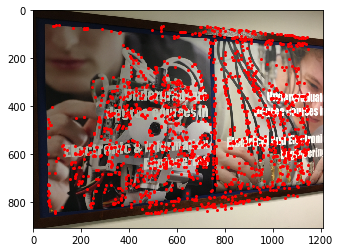

In [54]:
displayLayedOverKeypointsPerOctave(normal_img, extremaarray2) #just to show things

In [55]:
keypoint_list1=formulateKeypointList(extremaarray1, pyrlvl1, gkern(25,3))
keypoint_list2=formulateKeypointList(extremaarray2, pyrlvl2, gkern(25,3))
keypoint_list3=formulateKeypointList(extremaarray3, pyrlvl3, gkern(25,3))
keypoint_list4=formulateKeypointList(extremaarray4, pyrlvl4, gkern(25,3))

In [56]:
reshaped_keypoint_list1=reshapeKeypointList(keypoint_list1)
reshaped_keypoint_list2=reshapeKeypointList(keypoint_list2)
reshaped_keypoint_list3=reshapeKeypointList(keypoint_list3)
reshaped_keypoint_list4=reshapeKeypointList(keypoint_list4)

720


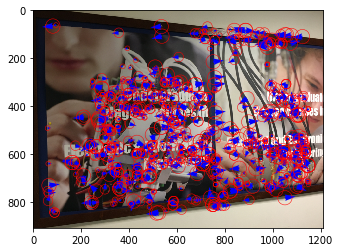

In [57]:
displayLayedOverCircleKeypointsPerOctave(normal_img, reshaped_keypoint_list2)
print(len(reshaped_keypoint_list2))

In [58]:
reshaped_keypoint_list1=concDescriptorToKeypointList(pyrlvl1, reshaped_keypoint_list1, gkern(18,3))
reshaped_keypoint_list2=concDescriptorToKeypointList(pyrlvl2, reshaped_keypoint_list2, gkern(18,3))
reshaped_keypoint_list3=concDescriptorToKeypointList(pyrlvl3, reshaped_keypoint_list3, gkern(18,3))
reshaped_keypoint_list4=concDescriptorToKeypointList(pyrlvl4, reshaped_keypoint_list4, gkern(18,3))

In [59]:
import csv

for s in range (1,5):
    list = locals()['reshaped_keypoint_list{0}'.format(s)]
    l = len(list)
    print(l)
    name1 = '/home/sherif/workspace/pythonCode/courses2/'"oct_" + str(s) + ".csv"
    name2 = '/home/sherif/workspace/pythonCode/courses2/'"oct_" + str(s) +"_descriptorData" +".csv"
    
    with open(name1,'w', newline='') as fp:
        a=csv.writer(fp, delimiter=',')
        for i in range (0, l):
            data = [[list[i][0],list[i][1],list[i][2],list[i][3]]]
            a.writerows(data)

    with open(name2,'w', newline='') as fp:
        b=csv.writer(fp, delimiter=',')
        for i in range (0, l):
            A = [list[i][-1][0:]]
            b.writerows(A)


1803
720
248
20


(2420, 1814)
(1814, 2420, 3)
3650
(1210, 907)
(907, 1210, 3)
1457
(605, 453)
(453, 605, 3)
457
(302, 226)
(226, 302, 3)
20


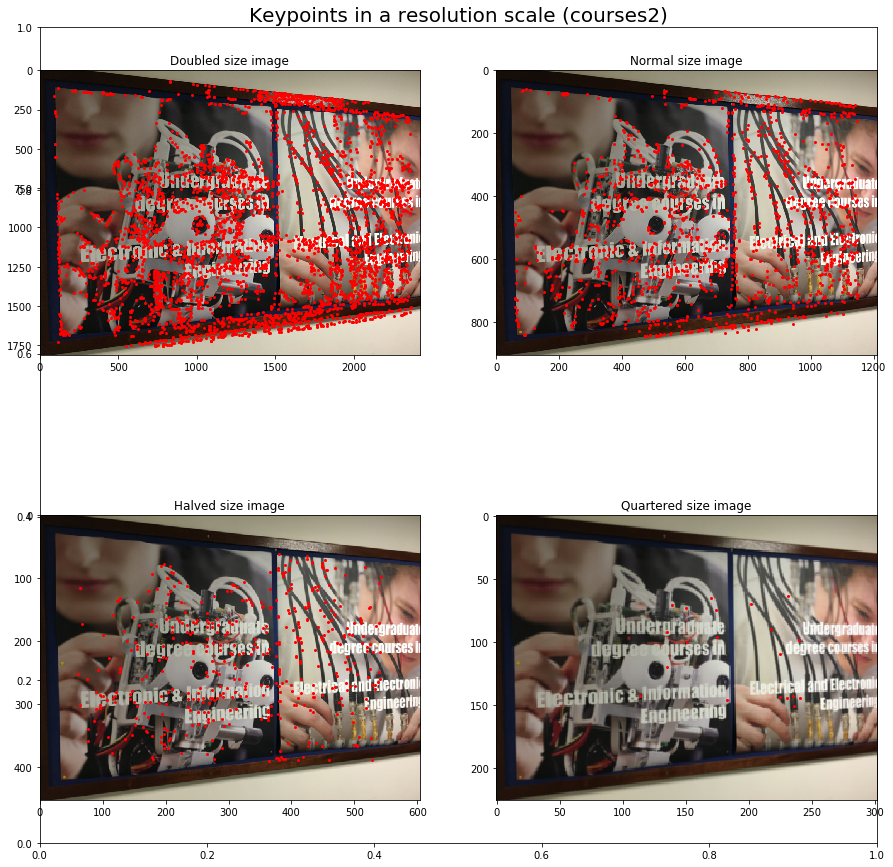

In [60]:
#import matplotlib.gridspec as gridspec

#%matplotlib inline  
fig = plt.figure(figsize=(15,15))

plt.title("Keypoints in a resolution scale (courses2)", fontsize=20)

ax1=fig.add_subplot(2,2,1)
ax1.title.set_text('Doubled size image')
displayLayedOverKeypointsPerOctave(doubled_img, extremaarray1)

ax2=fig.add_subplot(2,2,2)
ax2.title.set_text('Normal size image')
displayLayedOverKeypointsPerOctave(normal_img, extremaarray2)

ax3=fig.add_subplot(2,2,3)
ax3.title.set_text('Halved size image')
displayLayedOverKeypointsPerOctave(halved_img, extremaarray3)

ax4=fig.add_subplot(2,2,4)
ax4.title.set_text('Quartered size image')
displayLayedOverKeypointsPerOctave(quartered_img, extremaarray4)

plt.savefig('courses2_keypoints.pdf')
plt.savefig('courses2_keypoints.png')
#plt.show()